# 3DXRD segmentation notebook for Frelon-ish detectors  
__Written by Haixing Fang, Jon Wright and James Ball__  
__Date: 21/02/2025__

This notebook will help you to extract the locations of diffraction peaks on your detector images.  
It will also merge together your 2D spots (on a stack of detector images with different omega angles).  
We merge across omega because we often see the same spot twice on multiple detector images.  
The results are saved to the PROCESSED_DATA folder of the experiment, inside the sample and dataset folders that you select within this notebook

__NOTE: These notebooks are under active development
They require the latest version of ImageD11 from Git to run.__  
If you don't have this set up yet, you can run the below cell.  
It will automatically download and install ImageD11 to your home directory

In [1]:
exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())

In [2]:
# this cell is tagged with 'parameters'
# to view the tag, select the cell, then find the settings gear icon (right or left sidebar) and look for Cell Tags

PYTHONPATH = setup_ImageD11_from_git( ) # ( os.path.join( os.environ['HOME'],'Code'), 'ImageD11_git' )

# Experts : update these files for your detector if you need to

# give dx/dy as tuple instead of spline
# Since 2024: there is no good spline for a detector at ID11. You probably want to use an e2dx, e2dy file
# You can provide this as a simple string:
# splinefile = '/path/to/spline.spline'
# or as a tuple of strings for e2dx/e2dy files
splinefile = ('/data/id11/3dxrd/inhouse/Frelon36/frelon36_spline_20240604_dx.edf','/data/id11/3dxrd/inhouse/Frelon36/frelon36_spline_20240604_dy.edf')
bgfile = None     #  'bg.edf'
maskfile = '/data/id11/inhouse1/ewoks/detectors/files/Frelon2k_C36/mask.edf'

detector = "frelon3"  # fixme - guess this from masterfile + scan
omegamotor = "diffrz"
dtymotor = "diffty"

# Default segmentation options
options = {
    "bgfile":bgfile,
    "maskfile":maskfile,
    "threshold":70,
    "smoothsigma":1.0,
    "bgc":0.9,
    "minpx":3,
    "m_offset_thresh":100,
    "m_ratio_thresh":150,
}

# EXPERTS: These can be provided as papermill parameters. Users, leave these as None for now...
dataroot = None
analysisroot = None
sample = None
dataset = None
scans = ["1.1",]

dset_prefix = "top_"  # some common string in the names of the datasets if processing multiple scans

# Setting path via: 
sys.path.insert(0, /home/esrf/james1997a/Code/ImageD11 )


# Running from: /home/esrf/james1997a/Code/ImageD11/ImageD11/__init__.py


In [3]:
# Parameters
splinefile = [
    "/data/id11/inhouse2/test_data_3DXRD/TDXRD/FeAu/pars/frelon36_spline_20240604_dx.edf",
    "/data/id11/inhouse2/test_data_3DXRD/TDXRD/FeAu/pars/frelon36_spline_20240604_dy.edf",
]
bgfile = None
maskfile = "/data/id11/inhouse2/test_data_3DXRD/TDXRD/FeAu/pars/mask.edf"
detector = "frelon3"
omegamotor = "diffrz"
dtymotor = "diffty"
options = {
    "bgfile": None,
    "maskfile": "/data/id11/inhouse2/test_data_3DXRD/TDXRD/FeAu/pars/mask.edf",
    "threshold": 70,
    "smoothsigma": 1.0,
    "bgc": 0.9,
    "minpx": 3,
    "m_offset_thresh": 100,
    "m_ratio_thresh": 150,
}
PYTHONPATH = "../"
dataroot = "/data/id11/inhouse2/test_data_3DXRD/TDXRD/FeAu/RAW_DATA/"
analysisroot = "/data/id11/inhouse2/test_data_3DXRD/TDXRD/FeAu/PROCESSED_DATA/20250221_JADB/friedel"
sample = "FeAu_0p5_tR"
dataset = "ff1"


In [4]:
import fabio
import numpy as np
import matplotlib.pyplot as plt

import ImageD11.sinograms.dataset
import ImageD11.sinograms.lima_segmenter
import ImageD11.sinograms.assemble_label
import ImageD11.sinograms.properties
from ImageD11.nbGui import nb_utils as utils
from ImageD11.nbGui import segmenter_gui
from ImageD11.frelon_peaksearch import worker, segment_dataset, guess_bg

%matplotlib widget

In [5]:
# Set up the file paths. Edit this if you are not at ESRF or not using the latest data policy.
if dataroot is None:
    dataroot, analysisroot = segmenter_gui.guess_ESRF_paths() 

if len(dataroot)==0:
    print("Please fix in the dataroot and analysisroot folder names above!!")
print('dataroot =',repr(dataroot))
print('analysisroot =',repr(analysisroot))

dataroot = '/data/id11/inhouse2/test_data_3DXRD/TDXRD/FeAu/RAW_DATA/'
analysisroot = '/data/id11/inhouse2/test_data_3DXRD/TDXRD/FeAu/PROCESSED_DATA/20250221_JADB/friedel'


In [6]:
# List the samples available:
segmenter_gui.printsamples(dataroot)

Samples:
	 FeAu_0p5_tR


In [7]:
# USER: Decide which sample
if sample is None:
    sample = 'sample'

In [8]:
# List the datasets for that sample:
segmenter_gui.printdatasets( dataroot, sample )

Datsets:
	 ff1
	ff2
	ff3
	ff4
	ff5
	ff6


In [9]:
# USER: Decide which dataset
if dataset is None:
    dataset = "dataset"

In [10]:
# create ImageD11 dataset object

ds = ImageD11.sinograms.dataset.DataSet(dataroot=dataroot,
                                        analysisroot=analysisroot,
                                        sample=sample,
                                        dset=dataset,
                                        detector=detector,
                                        omegamotor=omegamotor,
                                        dtymotor=dtymotor)
ds.import_all(scans=scans)
if isinstance(splinefile, (tuple, list)) and len(splinefile) == 1:
    # we have ("splinefile", )
    ds.splinefile = splinefile[0]  # take the splinefile out of the tuple
elif isinstance(splinefile, (tuple, list)):
    # we have (e2dx, e2dy)
    ds.e2dxfile, ds.e2dyfile = splinefile
else:
    # we have "splinefile"
    ds.splinefile = splinefile
ds.maskfile = maskfile
ds.bgfile = bgfile
ds.save()
rawdata_path = ds.dataroot

Scan title finterlaced diffrz 0 0.25 0.1 1440 mode=ZIGZAG


In [11]:
# normally not needed:

# bg = guess_bg( ds )
# plt.imshow(bg)
# fabio.edfimage.edfimage(bg).save('bg.edf')
# plt.colorbar()
# ds.bgfile = 'bg.edf'

Using frame 2 from scan 1.1


interactive(children=(IntSlider(value=70, description='Threshold:', max=10000), FloatSlider(value=1.0, descrip…

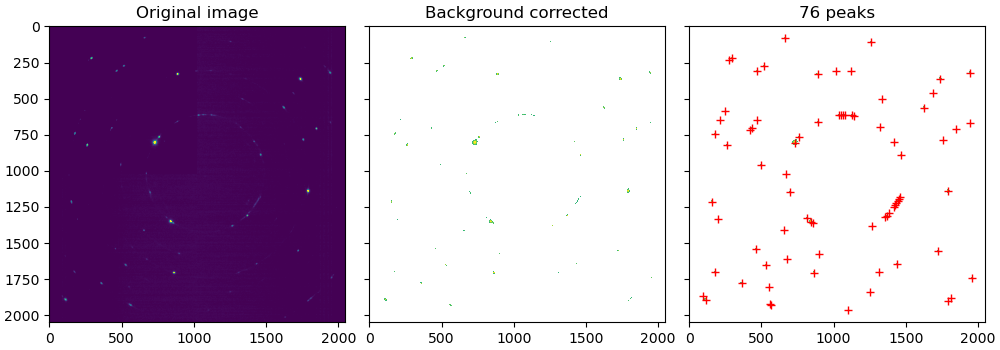

In [12]:
ui = segmenter_gui.FrelonSegmenterGui(ds, worker, segment_dataset, **options)

In [13]:
options = ui.getopts()
print(options)

options =  {'bgfile': None, 'maskfile': '/data/id11/inhouse2/test_data_3DXRD/TDXRD/FeAu/pars/mask.edf', 'threshold': 70, 'smoothsigma': 1.0, 'bgc': 0.9, 'minpx': 3, 'm_offset_thresh': 100, 'm_ratio_thresh': 150}
{'bgfile': None, 'maskfile': '/data/id11/inhouse2/test_data_3DXRD/TDXRD/FeAu/pars/mask.edf', 'threshold': 70, 'smoothsigma': 1.0, 'bgc': 0.9, 'minpx': 3, 'm_offset_thresh': 100, 'm_ratio_thresh': 150}


In [14]:
# now we run the segmenter on all our data

cf_2d, cf_3d = segment_dataset(ds, options)

  0%|          | 0/1440 [00:00<?, ?it/s]

Making 3D merge
made trees
connected components


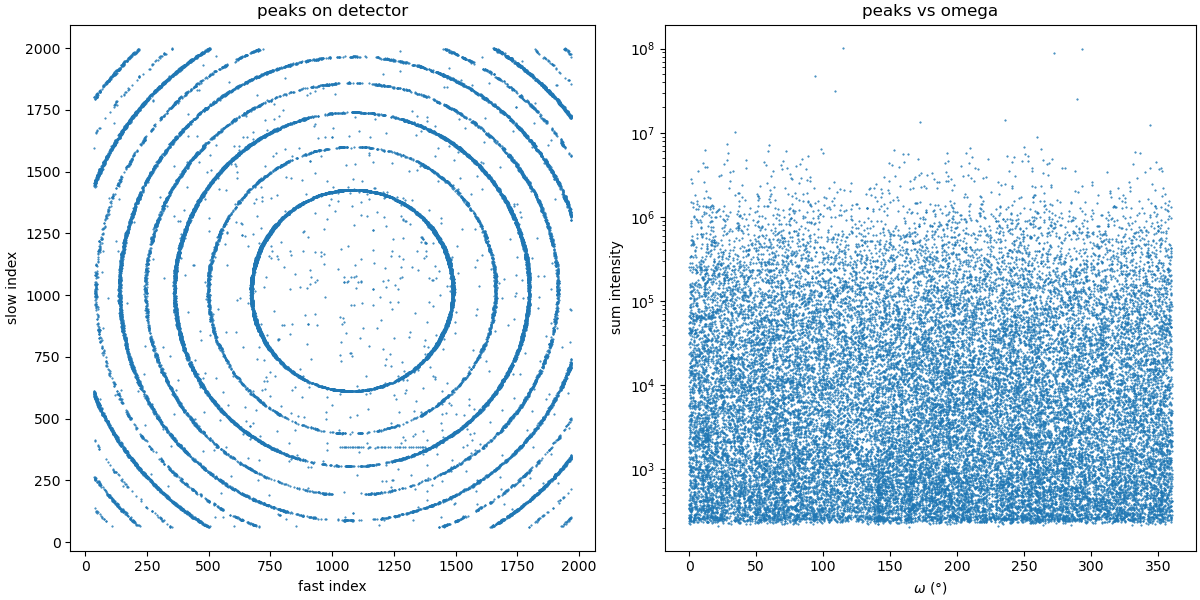

In [15]:
# display some peaks
f,a=plt.subplots(1,2,figsize=(12,6), layout='constrained')
a[0].plot(cf_3d.f_raw,cf_3d.s_raw,'.',ms=1)
a[0].set(xlabel='fast index', ylabel='slow index',aspect='equal', title='peaks on detector')
a[1].plot(cf_3d.omega,cf_3d.sum_intensity,'.',ms=1)
a[1].set(xlabel=r'$\omega~(\degree)$',ylabel='sum intensity',yscale='log',title='peaks vs omega')
plt.show()

In [16]:
ImageD11.columnfile.colfile_to_hdf(cf_2d, ds.col2dfile)
ImageD11.columnfile.colfile_to_hdf(cf_3d, ds.col3dfile)

In [17]:
ds.save()